In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=6


In [2]:
# import torch
import jax
import jax.numpy as jnp
import flax
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from meta_expl.explainers import load_explainer, create_explainer
from meta_expl.models import load_model, create_model
from meta_expl.data.cifar100 import dataloader, load_data

### define args

In [3]:
# arguments
arch = 'vit-base'
setup = 'static_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"
seed = 9
batch_size = 16
max_len = 32*32
num_classes = 100
task_type = "classification"
modality = "image"

teacher_dir = 'data/cifar100-vit-models/teacher_dir'
teacher_expl_dir = 'data/cifar100-vit-models/teacher_expl_dir'
student_dir = 'data/cifar100-vit-models/student_dir'
student_expl_dir = 'data/cifar100-vit-models/student_expl_dir'

In [4]:
from transformers import ViTFeatureExtractor
tokenizer = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vocab_size = None

In [5]:
# create dummy inputs for model instantiation
dummy_inputs = {"pixel_values": jnp.ones((batch_size, 3, 224, 224))}

### load models and explainers

In [6]:
%env XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda/

env: XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda/


In [7]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, dummy_inputs, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(teacher_expl_dir, dummy_inputs, state=dummy_state)
student, student_params, dummy_state = load_model(student_dir, dummy_inputs, batch_size, max_len)
student_explainer, student_explainer_params = load_explainer(student_expl_dir, dummy_inputs, state=dummy_state)

In [8]:
from meta_expl.utils import PRNGSequence
keyseq = PRNGSequence(seed)

teacher_explainer_params_non_trained={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': None,
    'head_idx': None
}
teacher_explainer_non_trained, teacher_explainer_params_non_trained = create_explainer(
    key=next(keyseq),
    inputs=dummy_inputs,
    state=dummy_state,
    explainer_type='attention_explainer',
    explainer_args=teacher_explainer_params_non_trained,
)

In [9]:
best_head_teacher_explainer_params={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': 9,  #9, None
    'head_idx': 5,  #5, None
}
best_head_teacher_explainer, best_head_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='attention_explainer', 
    explainer_args=best_head_teacher_explainer_params
)

In [10]:
best_layer_teacher_explainer_params={
    'normalize_head_coeffs': 'sparsemax',
    'normalizer_fn': 'softmax',
    'aggregator_idx': 'mean',
    'aggregator_dim': 'row',
    'init_fn': 'uniform',
    'layer_idx': 11,  #9, None
    'head_idx': None,  #5, None
}
best_layer_teacher_explainer, best_layer_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='attention_explainer', 
    explainer_args=best_layer_teacher_explainer_params
)

In [11]:
def id_fn(*args, **kwargs):
    return args[0]

input_gradient_teacher_explainer_params={
    'normalizer_fn': id_fn,
}
input_gradient_teacher_explainer, input_gradient_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='gradient_input_explainer', 
    explainer_args=input_gradient_teacher_explainer_params,
    model_extras={
        "grad_fn": teacher.apply(
            teacher_params, dummy_inputs, method=teacher.embeddings_grad_fn
        )
    }
)

In [12]:
int_gradient_teacher_explainer_params={
    'normalizer_fn': id_fn,
}
int_gradient_teacher_explainer, int_gradient_teacher_explainer_params = create_explainer(
    key=next(keyseq), 
    inputs=dummy_inputs, 
    state=dummy_state, 
    explainer_type='integrated_gradients_explainer', 
    explainer_args=int_gradient_teacher_explainer_params,
    model_extras={
        "grad_fn": teacher.apply(
            teacher_params, dummy_inputs, method=teacher.embeddings_grad_fn
        )
    }
)

### look at the coefficients

In [13]:
sparsemax(teacher_explainer_params_non_trained['params']['head_coeffs']).reshape(12, 12)

DeviceArray([[0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.00694444,
              0.00694444, 0.00694444],
             [0.00694444, 0.00694444, 0.00694444, 0.00694444, 0.0

In [14]:
sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)

DeviceArray([[0.        , 0.        , 0.03754304, 0.03200413, 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.07093407, 0.        , 0.        ,
              0.        , 0.        ],
             [0.02360005, 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.04277126],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 0.        ],
             [0.        , 0.        , 0.        , 0.        , 0.0

In [15]:
hc = sparsemax(teacher_explainer_params['params']['head_coeffs']).reshape(12, 12)
for a, b in zip(*hc.nonzero()):
    print(a, b, hc[a,b])

0 2 0.037543043
0 3 0.032004133
1 7 0.07093407
2 0 0.023600047
2 11 0.042771257
5 4 0.057434496
5 6 0.020644484
6 10 0.026544234
10 0 0.029145654
10 1 0.05205636
10 2 0.0201117
10 4 0.0227738
10 5 0.041795414
10 6 0.019926744
10 7 0.028310832
10 8 0.018509509
10 10 0.005542064
11 0 0.07020469
11 1 0.017539144
11 2 0.050467845
11 4 0.0834601
11 5 0.035108786
11 6 0.04038902
11 7 0.029967437
11 8 0.043612216
11 9 0.03187661
11 11 0.047726218


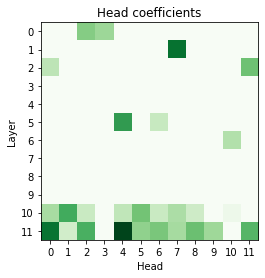

In [16]:
coeffs = np.asarray(hc)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(coeffs, cmap='Greens')
ax.set_xticks(list(range(12)))
ax.set_yticks(list(range(12)))
ax.set_xlabel('Head')
ax.set_ylabel('Layer')
ax.set_title('Head coefficients')
plt.savefig('head_coeffs_vit_vertical.pdf', dpi=300, bbox_inches='tight')

### load data

In [17]:
train_data = load_data(setup, "train")
valid_data = load_data(setup, "valid")
test_data = load_data(setup, "test")
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm',]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

## plot some samples

In [18]:
test_data[0]

{'img': <PIL.Image.Image image mode=RGB size=32x32 at 0x7F75E034C7C0>,
 'fine_label': 60,
 'coarse_label': 10}

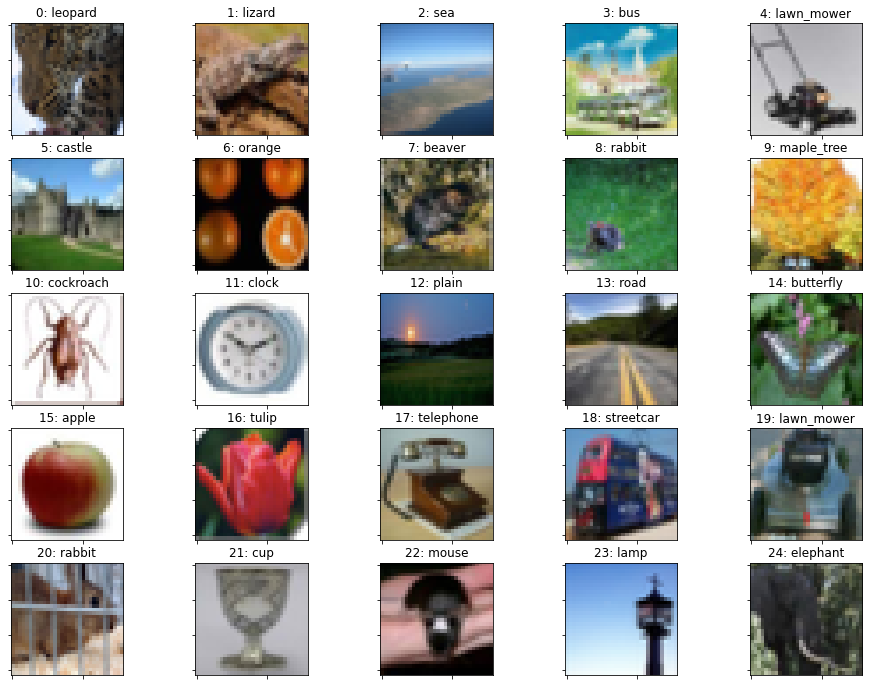

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(16, 12))
for i in range(25):
    ax = axs[i//5, i%5]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    sample = test_data[i+100]
    ax.imshow(sample['img'])
    ax.set_title('{}: {}'.format(i, labels[sample['fine_label']]))

## plot explanations

In [20]:
from captum.attr import visualization

In [21]:
def get_expl(data, idx, t, t_p, t_e, t_e_p, is_grad_based=False):
    x, y = next(dataloader([data[idx]], tokenizer=tokenizer, batch_size=1, max_len=None, shuffle=False))
    y_teacher, teacher_attn = t.apply(t_p, **x, deterministic=True)
    y_teacher = jnp.argmax(y_teacher, axis=-1) if task_type == "classification" else y_teacher
    if is_grad_based:
        teacher_extras = {
            "grad_fn": t.apply(t_p, x, method=t.embeddings_grad_fn)
        }
        teacher_expl, _ = t_e.apply(t_e_p, x, teacher_attn, **teacher_extras)
    else:
        teacher_expl, _ = t_e.apply(t_e_p, x, teacher_attn)


    return teacher_expl.tolist()[0], y_teacher.tolist()[0], y[0]


## save

In [25]:
import os
from matplotlib.colors import LinearSegmentedColormap

def save_expl(data, idx, method, t=None, t_p=None, t_e=None, t_e_p=None, is_grad_based=False, show=False):
    # x = np.asarray(d['x'])
    x = np.asarray(data[idx]['img'].resize((224, 224)))
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    [ax.spines[a].set_linewidth(1) for a in ['top','bottom','left','right']]
    expl, y_t, y_g = get_expl(data, idx, t, t_p, t_e, t_e_p, is_grad_based=is_grad_based)
    expl = np.asarray(expl)
    e = expl[1:].reshape(14, 14)
    e = np.repeat(np.repeat(e, 16, axis=0), 16, axis=1)
    e = e[:, :, None]
    
    if method is None:
        fname = 'figs-vit-red-blue/{}:{}:{}/{}'.format(idx, labels[y_t], labels[y_g], 'image.png')
        ax.imshow(x)
        
    else:
        fname = 'figs-vit-red-blue/{}:{}:{}/{}'.format(idx, labels[y_t], labels[y_g], '{}.png'.format(method))
        
        kwargs = dict(
            cmap='Blues'
        )
        if is_grad_based:
            kwargs=dict(
#                 cmap = LinearSegmentedColormap.from_list("RdWhBl", ["red", "white", "blue"]),
                cmap='RdBu',
                vmin=-1,
                vmax=1,
            )
            # e = (e - np.min(e)) / (np.max(e) - np.min(e))
            # e = e*2 - 1
            # e = jnp.tanh(e)
            e = e / np.max(np.abs(e))
        ax.imshow(e, **kwargs)
        
    
    dname = os.path.dirname(fname)
    if not os.path.exists(dname):
        os.makedirs(dname, exist_ok=True)
    print('Saving to: ', fname)
    plt.savefig(fname, bbox_inches='tight', dpi=300)
    if not show:
        plt.close()
    

In [27]:
from random import shuffle
num_samples = 100
idxs = list(range(len(valid_data)))
shuffle(idxs)
idxs = idxs[:num_samples]
idxs = [5]
idxs = [1044, 1057, 1073, 1075, 1112, 1157, 1164, 1209, 1337, 1343, 1384, 1419, 1427, 143, 1483, 1553, 1566, 158, 1624, 1658, 1687, 1855, 1921, 1950, 2038, 2052, 2114, 2172, 2185, 220, 2276, 2357, 2372, 2391, 2420, 2444, 245, 2507, 2559, 2595, 2651, 2710, 274, 2779, 2802, 2846, 2888, 2902, 2916, 2941, 3243, 3350, 3367, 3394, 33, 3425, 3443, 3472, 3473, 34, 3502, 3590, 3618, 3622, 3782, 3830, 3946, 4005, 4046, 4100, 412, 4230, 4250, 4337, 437, 4404, 443, 4510, 4560, 4571, 4574, 4581, 4620, 4674, 4684, 4700, 4708, 4864, 4896, 4987, 516, 574, 5, 704, 740, 749, 860, 866, 901, 946, 966]

for idx in idxs:
    save_expl(
        valid_data, 
        idx, 
        None, 
        teacher, 
        teacher_params, 
        teacher_explainer, 
        teacher_explainer_params,
    )
    
    save_expl(
        valid_data, 
        idx, 
        'attention_learned', 
        teacher, 
        teacher_params, 
        teacher_explainer, 
        teacher_explainer_params,          
    )
    
    save_expl(
        valid_data, 
        idx, 
        'attention_all_layers', 
        teacher, 
        teacher_params, 
        teacher_explainer_non_trained, 
        teacher_explainer_params_non_trained,          
    )
    
    save_expl(
        valid_data, 
        idx, 
        'attention_last_layer', 
        teacher, 
        teacher_params, 
        best_layer_teacher_explainer, 
        best_layer_teacher_explainer_params,
    )
    
    save_expl(
        valid_data, 
        idx, 
        'gradient_x_input', 
        teacher, 
        teacher_params, 
        input_gradient_teacher_explainer, 
        input_gradient_teacher_explainer_params,
        is_grad_based=True
    )
    
    save_expl(
        valid_data, 
        idx, 
        'int_gradients', 
        teacher, 
        teacher_params, 
        int_gradient_teacher_explainer, 
        int_gradient_teacher_explainer_params,
        is_grad_based=True
    )
    

Saving to:  figs-vit-red-blue/1044:wardrobe:wardrobe/image.png
Saving to:  figs-vit-red-blue/1044:wardrobe:wardrobe/attention_learned.png
Saving to:  figs-vit-red-blue/1044:wardrobe:wardrobe/attention_all_layers.png
Saving to:  figs-vit-red-blue/1044:wardrobe:wardrobe/attention_last_layer.png
Saving to:  figs-vit-red-blue/1044:wardrobe:wardrobe/gradient_x_input.png
Saving to:  figs-vit-red-blue/1044:wardrobe:wardrobe/int_gradients.png
Saving to:  figs-vit-red-blue/1057:skyscraper:skyscraper/image.png
Saving to:  figs-vit-red-blue/1057:skyscraper:skyscraper/attention_learned.png
Saving to:  figs-vit-red-blue/1057:skyscraper:skyscraper/attention_all_layers.png
Saving to:  figs-vit-red-blue/1057:skyscraper:skyscraper/attention_last_layer.png
Saving to:  figs-vit-red-blue/1057:skyscraper:skyscraper/gradient_x_input.png
Saving to:  figs-vit-red-blue/1057:skyscraper:skyscraper/int_gradients.png
Saving to:  figs-vit-red-blue/1073:squirrel:squirrel/image.png
Saving to:  figs-vit-red-blue/1073:

Saving to:  figs-vit-red-blue/1658:keyboard:keyboard/attention_learned.png
Saving to:  figs-vit-red-blue/1658:keyboard:keyboard/attention_all_layers.png
Saving to:  figs-vit-red-blue/1658:keyboard:keyboard/attention_last_layer.png
Saving to:  figs-vit-red-blue/1658:keyboard:keyboard/gradient_x_input.png
Saving to:  figs-vit-red-blue/1658:keyboard:keyboard/int_gradients.png
Saving to:  figs-vit-red-blue/1687:worm:worm/image.png
Saving to:  figs-vit-red-blue/1687:worm:worm/attention_learned.png
Saving to:  figs-vit-red-blue/1687:worm:worm/attention_all_layers.png
Saving to:  figs-vit-red-blue/1687:worm:worm/attention_last_layer.png
Saving to:  figs-vit-red-blue/1687:worm:worm/gradient_x_input.png
Saving to:  figs-vit-red-blue/1687:worm:worm/int_gradients.png
Saving to:  figs-vit-red-blue/1855:orchid:orchid/image.png
Saving to:  figs-vit-red-blue/1855:orchid:orchid/attention_learned.png
Saving to:  figs-vit-red-blue/1855:orchid:orchid/attention_all_layers.png
Saving to:  figs-vit-red-blue

Saving to:  figs-vit-red-blue/2559:worm:worm/gradient_x_input.png
Saving to:  figs-vit-red-blue/2559:worm:worm/int_gradients.png
Saving to:  figs-vit-red-blue/2595:chimpanzee:chimpanzee/image.png
Saving to:  figs-vit-red-blue/2595:chimpanzee:chimpanzee/attention_learned.png
Saving to:  figs-vit-red-blue/2595:chimpanzee:chimpanzee/attention_all_layers.png
Saving to:  figs-vit-red-blue/2595:chimpanzee:chimpanzee/attention_last_layer.png
Saving to:  figs-vit-red-blue/2595:chimpanzee:chimpanzee/gradient_x_input.png
Saving to:  figs-vit-red-blue/2595:chimpanzee:chimpanzee/int_gradients.png
Saving to:  figs-vit-red-blue/2651:pear:pear/image.png
Saving to:  figs-vit-red-blue/2651:pear:pear/attention_learned.png
Saving to:  figs-vit-red-blue/2651:pear:pear/attention_all_layers.png
Saving to:  figs-vit-red-blue/2651:pear:pear/attention_last_layer.png
Saving to:  figs-vit-red-blue/2651:pear:pear/gradient_x_input.png
Saving to:  figs-vit-red-blue/2651:pear:pear/int_gradients.png
Saving to:  figs-

Saving to:  figs-vit-red-blue/3473:cup:cup/attention_last_layer.png
Saving to:  figs-vit-red-blue/3473:cup:cup/gradient_x_input.png
Saving to:  figs-vit-red-blue/3473:cup:cup/int_gradients.png
Saving to:  figs-vit-red-blue/34:tank:tank/image.png
Saving to:  figs-vit-red-blue/34:tank:tank/attention_learned.png
Saving to:  figs-vit-red-blue/34:tank:tank/attention_all_layers.png
Saving to:  figs-vit-red-blue/34:tank:tank/attention_last_layer.png
Saving to:  figs-vit-red-blue/34:tank:tank/gradient_x_input.png
Saving to:  figs-vit-red-blue/34:tank:tank/int_gradients.png
Saving to:  figs-vit-red-blue/3502:pear:pear/image.png
Saving to:  figs-vit-red-blue/3502:pear:pear/attention_learned.png
Saving to:  figs-vit-red-blue/3502:pear:pear/attention_all_layers.png
Saving to:  figs-vit-red-blue/3502:pear:pear/attention_last_layer.png
Saving to:  figs-vit-red-blue/3502:pear:pear/gradient_x_input.png
Saving to:  figs-vit-red-blue/3502:pear:pear/int_gradients.png
Saving to:  figs-vit-red-blue/3590:tr

Saving to:  figs-vit-red-blue/4560:willow_tree:pine_tree/gradient_x_input.png
Saving to:  figs-vit-red-blue/4560:willow_tree:pine_tree/int_gradients.png
Saving to:  figs-vit-red-blue/4571:elephant:elephant/image.png
Saving to:  figs-vit-red-blue/4571:elephant:elephant/attention_learned.png
Saving to:  figs-vit-red-blue/4571:elephant:elephant/attention_all_layers.png
Saving to:  figs-vit-red-blue/4571:elephant:elephant/attention_last_layer.png
Saving to:  figs-vit-red-blue/4571:elephant:elephant/gradient_x_input.png
Saving to:  figs-vit-red-blue/4571:elephant:elephant/int_gradients.png
Saving to:  figs-vit-red-blue/4574:porcupine:mouse/image.png
Saving to:  figs-vit-red-blue/4574:porcupine:mouse/attention_learned.png
Saving to:  figs-vit-red-blue/4574:porcupine:mouse/attention_all_layers.png
Saving to:  figs-vit-red-blue/4574:porcupine:mouse/attention_last_layer.png
Saving to:  figs-vit-red-blue/4574:porcupine:mouse/gradient_x_input.png
Saving to:  figs-vit-red-blue/4574:porcupine:mouse

Saving to:  figs-vit-red-blue/901:cockroach:cockroach/attention_last_layer.png
Saving to:  figs-vit-red-blue/901:cockroach:cockroach/gradient_x_input.png
Saving to:  figs-vit-red-blue/901:cockroach:cockroach/int_gradients.png
Saving to:  figs-vit-red-blue/946:plain:plain/image.png
Saving to:  figs-vit-red-blue/946:plain:plain/attention_learned.png
Saving to:  figs-vit-red-blue/946:plain:plain/attention_all_layers.png
Saving to:  figs-vit-red-blue/946:plain:plain/attention_last_layer.png
Saving to:  figs-vit-red-blue/946:plain:plain/gradient_x_input.png
Saving to:  figs-vit-red-blue/946:plain:plain/int_gradients.png
Saving to:  figs-vit-red-blue/966:snake:snake/image.png
Saving to:  figs-vit-red-blue/966:snake:snake/attention_learned.png
Saving to:  figs-vit-red-blue/966:snake:snake/attention_all_layers.png
Saving to:  figs-vit-red-blue/966:snake:snake/attention_last_layer.png
Saving to:  figs-vit-red-blue/966:snake:snake/gradient_x_input.png
Saving to:  figs-vit-red-blue/966:snake:snak

## viz

Saving to:  figs-vit-red-blue/114:butterfly:butterfly/image.png
Saving to:  figs-vit-red-blue/114:butterfly:butterfly/attention_learned.png
Saving to:  figs-vit-red-blue/114:butterfly:butterfly/attention_all_layers.png
Saving to:  figs-vit-red-blue/114:butterfly:butterfly/attention_last_layer.png
Saving to:  figs-vit-red-blue/114:butterfly:butterfly/gradient_x_input.png
Saving to:  figs-vit-red-blue/114:butterfly:butterfly/int_gradients.png


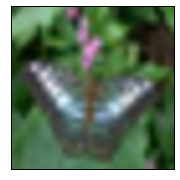

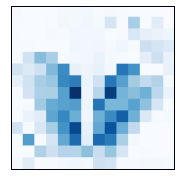

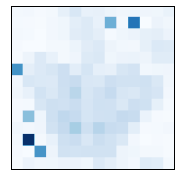

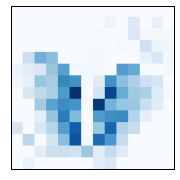

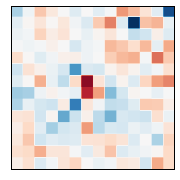

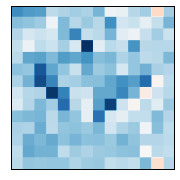

In [26]:
idxs = [114] #5,114

for idx in idxs:
    save_expl(
        test_data, 
        idx, 
        None, 
        teacher, 
        teacher_params, 
        teacher_explainer, 
        teacher_explainer_params,
        show=True,
    )
    
    save_expl(
        test_data, 
        idx, 
        'attention_learned', 
        teacher, 
        teacher_params, 
        teacher_explainer, 
        teacher_explainer_params,
        show=True,
    )
    
    save_expl(
        test_data, 
        idx, 
        'attention_all_layers', 
        teacher, 
        teacher_params, 
        teacher_explainer_non_trained, 
        teacher_explainer_params_non_trained, 
        show=True,
    )
    
    save_expl(
        test_data, 
        idx, 
        'attention_last_layer', 
        teacher, 
        teacher_params, 
        best_layer_teacher_explainer, 
        best_layer_teacher_explainer_params,
        show=True,
    )
    
    save_expl(
        test_data, 
        idx, 
        'gradient_x_input', 
        teacher, 
        teacher_params, 
        input_gradient_teacher_explainer, 
        input_gradient_teacher_explainer_params,
        is_grad_based=True,
        show=True,
    )
    
    save_expl(
        test_data, 
        idx, 
        'int_gradients', 
        teacher, 
        teacher_params, 
        int_gradient_teacher_explainer, 
        int_gradient_teacher_explainer_params,
        is_grad_based=True,
        show=True,
    )
    